In [1]:
import pandas as pd
from biom import Table
from gemelli.preprocessing import rclr_transformation
from gemelli.rpca import rpca
from skbio.stats.composition import clr
from scipy.spatial.distance import cdist
from skbio.stats import subsample_counts


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

### import the data

Data was obtained from here: https://github.com/riffomonas/distances

In [2]:
table_df = pd.read_csv('data/mice.shared', sep='\t', index_col=1).drop(['label','numOtus'], axis=1)
table_df = table_df[table_df.sum(1) > 1800].T
table_df = table_df[table_df.sum(1) > 10]
bt = Table(table_df.values, table_df.index, table_df.columns)
bt


362 x 348 <class 'biom.table.Table'> with 51547 nonzero entries (40% dense)

### Rarefaction with Bray-Curtis

In [3]:
import qiime2 as q2
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.diversity.actions import beta
from skbio import DistanceMatrix



In [6]:
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt_rare = rarefy(table, 1806).rarefied_table # value used in the video
bt_rare


<artifact: FeatureTable[Frequency] uuid: 1c402aa6-39c9-4bf8-b3f1-09c47036a363>

In [7]:
bc_dist = beta(bt_rare, 'braycurtis').distance_matrix.view(DistanceMatrix).to_data_frame()
bc_dist.head(5)


,F3D0,F3D1,F3D11,F3D125,F3D13,F3D141,F3D142,F3D143,F3D144,F3D145,...,M6D3,M6D364,M6D4,M6D45,M6D5,M6D6,M6D65,M6D7,M6D8,M6D9
F3D0,0.000000,0.383721,0.472315,0.302879,0.460687,0.323920,0.335548,0.320598,0.357697,0.376523,...,0.477852,0.407530,0.493909,0.345515,0.419158,0.523256,0.329457,0.474529,0.392027,0.489480
F3D1,0.383721,0.000000,0.555371,0.445183,0.575305,0.493909,0.510520,0.501107,0.555371,0.576412,...,0.492802,0.500554,0.629568,0.522702,0.478959,0.549834,0.501107,0.635659,0.460687,0.576966
F3D11,0.472315,0.555371,0.000000,0.452935,0.275748,0.408638,0.347730,0.430233,0.342746,0.311185,...,0.486711,0.647287,0.401993,0.482835,0.415282,0.430786,0.367663,0.370432,0.555371,0.459579
F3D125,0.302879,0.445183,0.452935,0.000000,0.404208,0.249169,0.264673,0.248616,0.277409,0.274086,...,0.466224,0.406977,0.472868,0.356589,0.379845,0.509967,0.329457,0.457918,0.444629,0.497785
F3D13,0.460687,0.575305,0.275748,0.404208,0.000000,0.375969,0.248616,0.375415,0.335548,0.288483,...,0.441307,0.640642,0.368217,0.499446,0.372647,0.379845,0.395903,0.369878,0.514950,0.410299


In [8]:
bc_dists_compare = bc_dist.stack().reset_index()
bc_dists_compare.columns = ['s1','s2','dist']
total_counts = table_df.sum(0)
bc_dists_compare['diffs'] = [abs(total_counts[x] - total_counts[y])
                             for x, y in zip(bc_dists_compare.s1, 
                                             bc_dists_compare.s2)]
bc_dists_compare.head(5)



,s1,s2,dist,diffs
0,F3D0,F3D0,0.000000,0.0
1,F3D0,F3D1,0.383721,1533.0
2,F3D0,F3D11,0.472315,7257.0
3,F3D0,F3D125,0.302879,3655.0
4,F3D0,F3D13,0.460687,7196.0


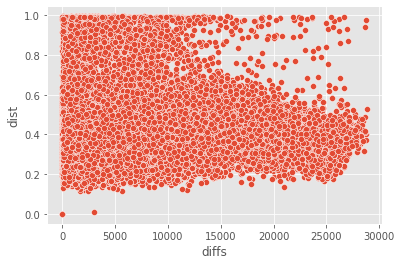

In [9]:
# plot results
sns.scatterplot(x='diffs', y='dist', data=bc_dists_compare)
plt.show()


### Analysis with the robust CLR + RPCA

In [10]:
# Note: the missing data is saved as NaNs _not_ zeros
rclr_transformation(bt).matrix_data.toarray()

array([[ 2.47291095,  1.18247055,  3.97677052, ...,  4.76842811,
         1.72276119,  2.00799237],
       [ 0.98607536,  1.61610653,  3.45320587, ...,  3.8498145 ,
         2.92469109,  3.46951016],
       [ 1.33889673, -0.42696737,  2.0754222 , ...,  3.98552375,
         1.08903743,  1.27228558],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., -1.99082716,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [11]:
# use RPCA (treat NaNs as missing)
dists_compare = rpca(bt)[1].to_data_frame().stack().reset_index()
dists_compare.columns = ['s1','s2','dist']
total_counts = table_df.sum(0)
dists_compare['diffs'] = [abs(total_counts[x] - total_counts[y])
                          for x, y in zip(dists_compare.s1, dists_compare.s2)]
dists_compare.head(5)


,s1,s2,dist,diffs
0,F3D0,F3D0,0.000000,0.0
1,F3D0,F3D1,1.163922,1533.0
2,F3D0,F3D11,1.774224,7257.0
3,F3D0,F3D125,0.978653,3655.0
4,F3D0,F3D13,2.176177,7196.0


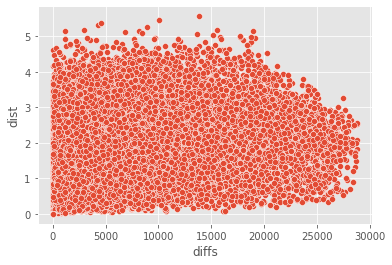

In [12]:
# plot results
sns.scatterplot(x='diffs', y='dist', data=dists_compare)
plt.show()
